In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import jcl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap

/home/shaurya/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

(117, 23732)


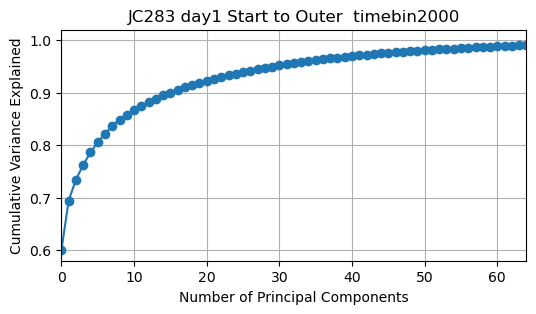

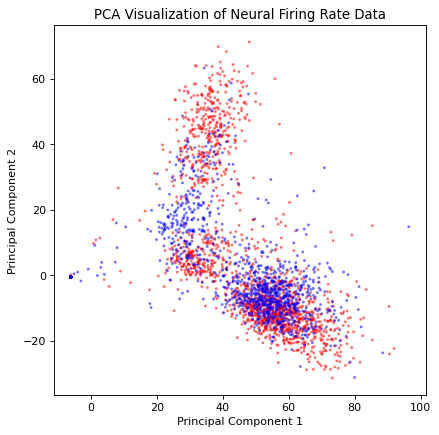

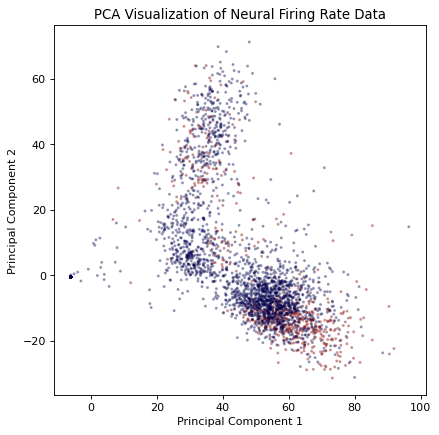

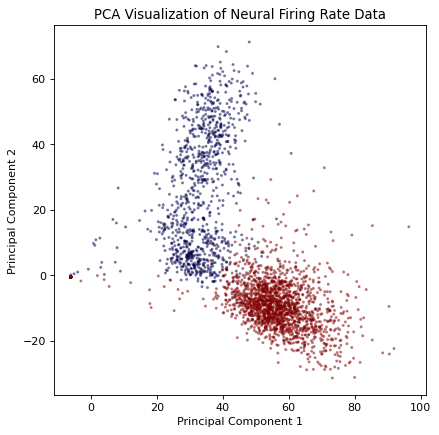

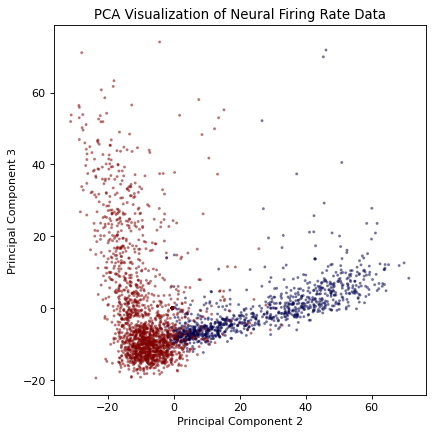

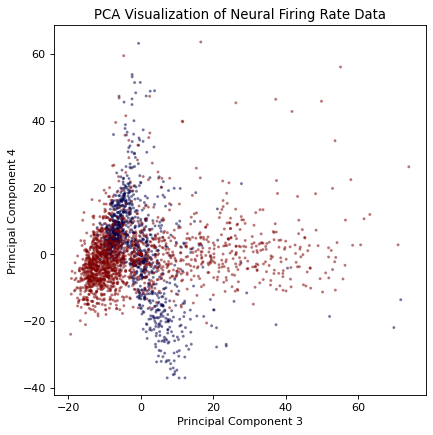

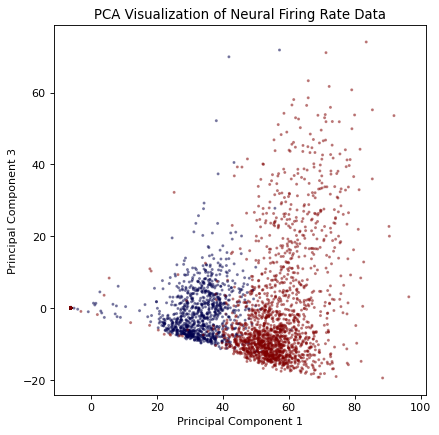

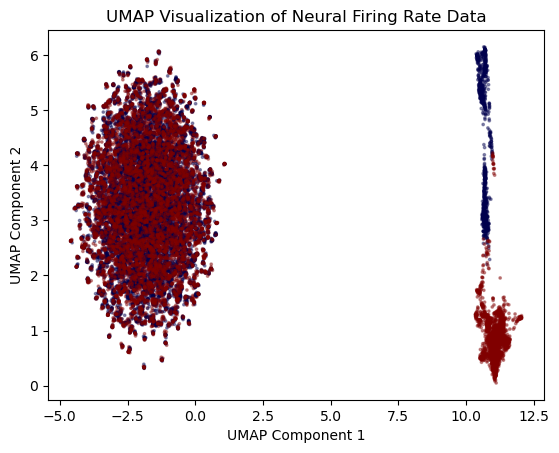

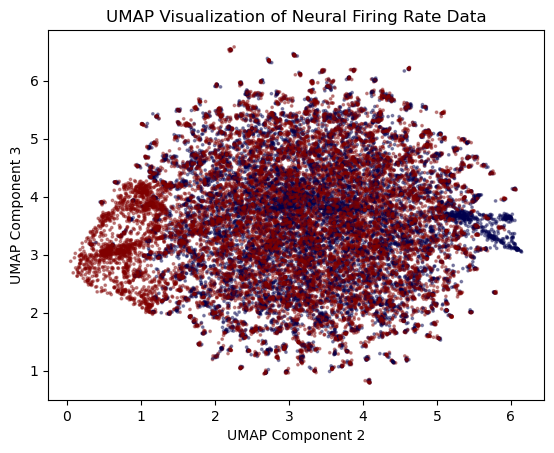

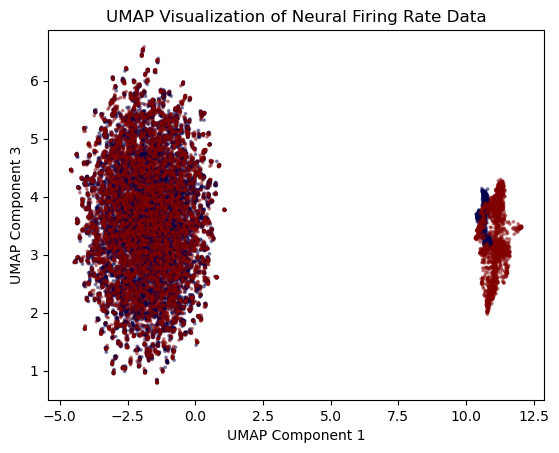

(69, 50332)


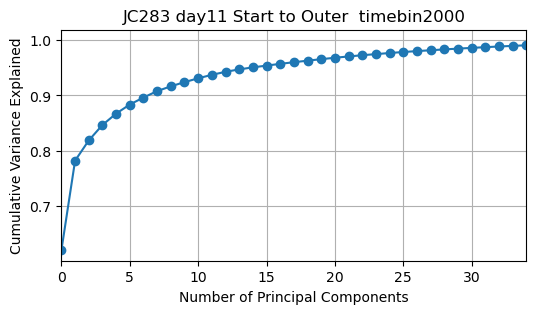

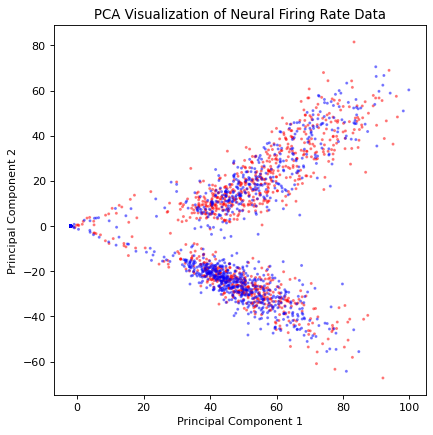

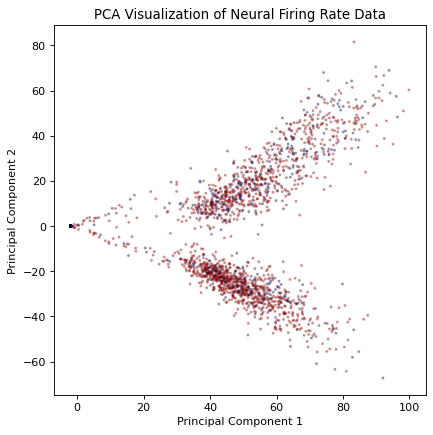

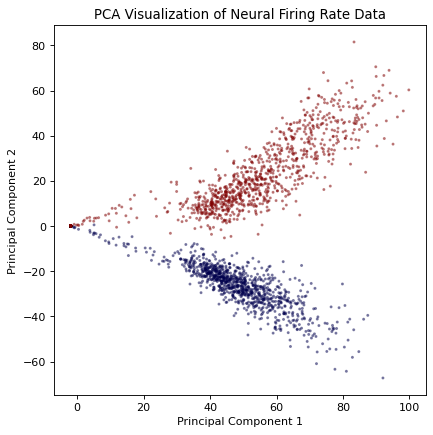

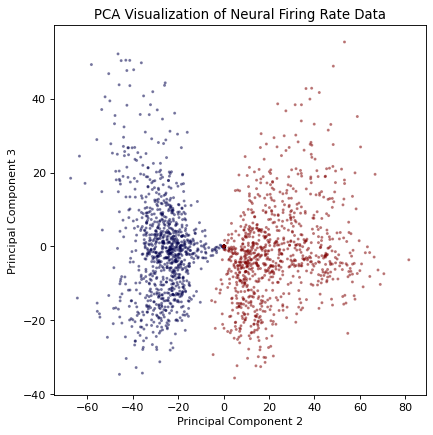

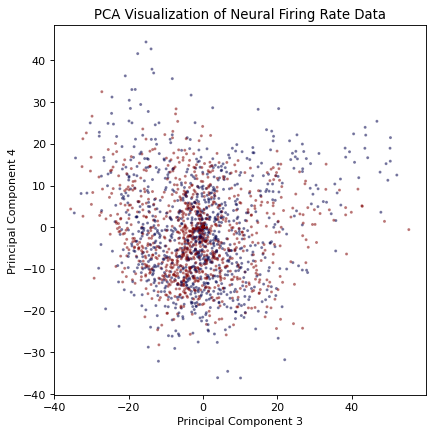

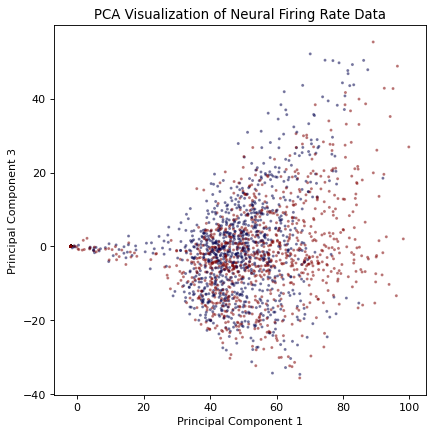

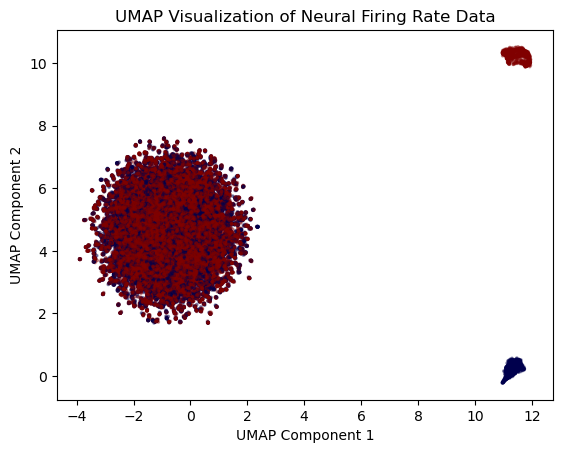

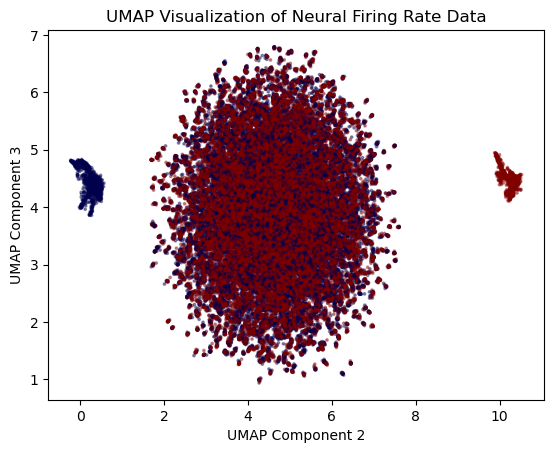

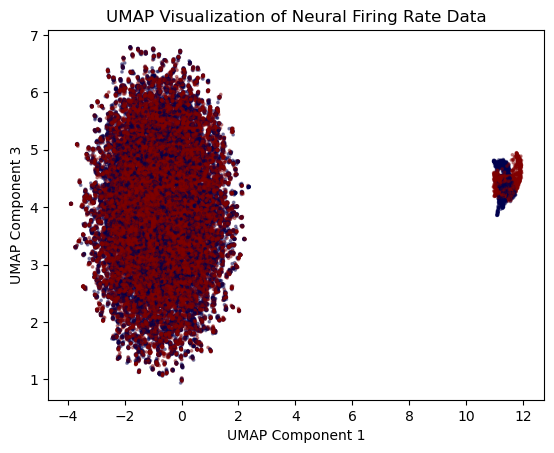

(117, 9502)


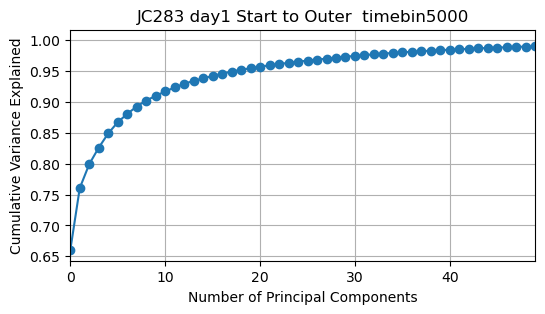

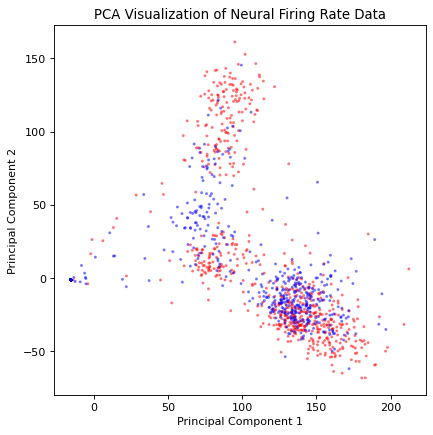

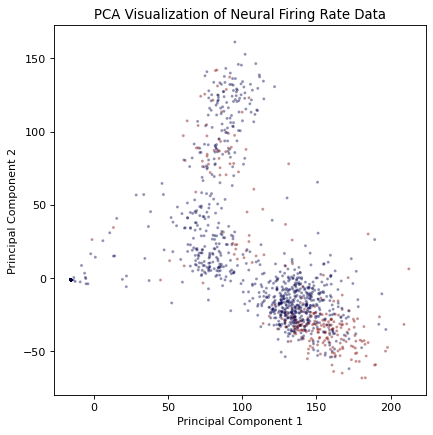

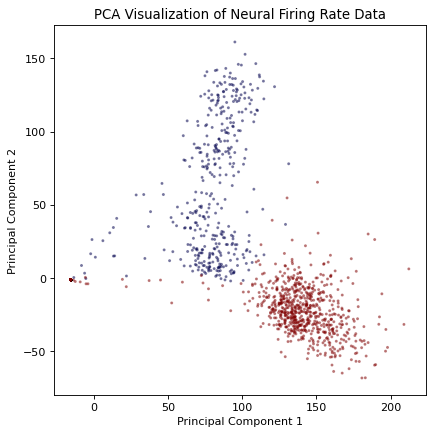

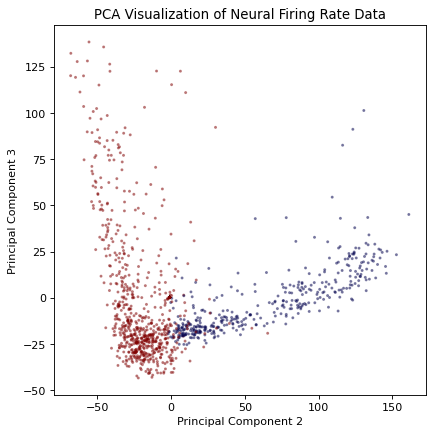

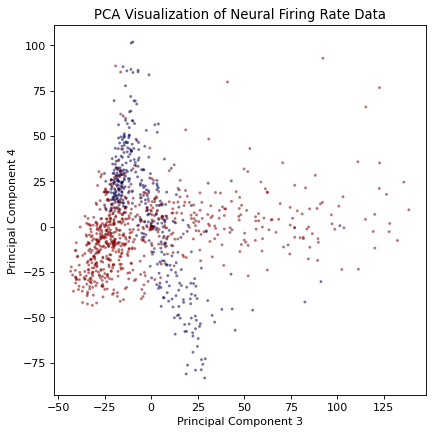

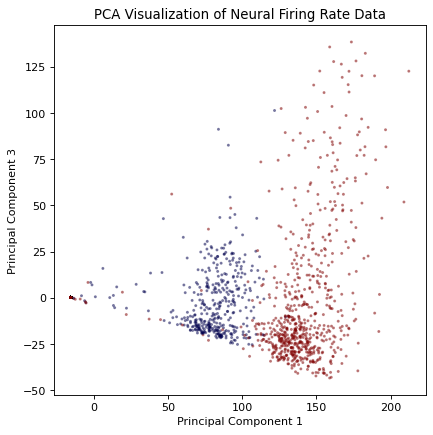

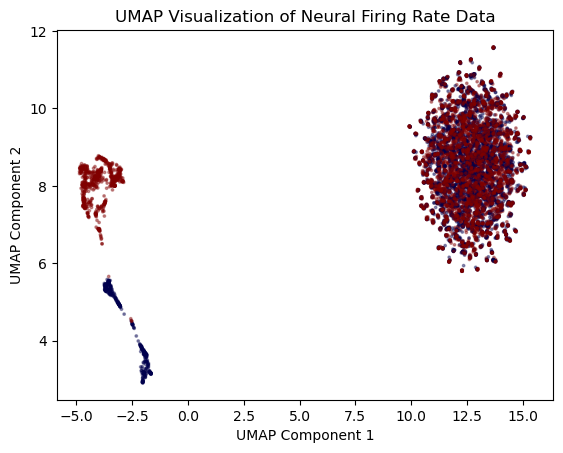

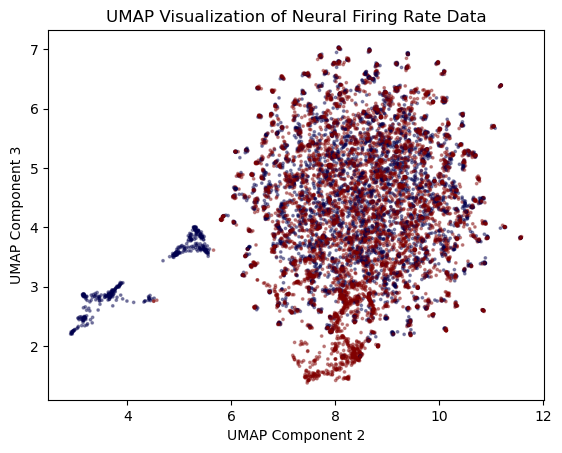

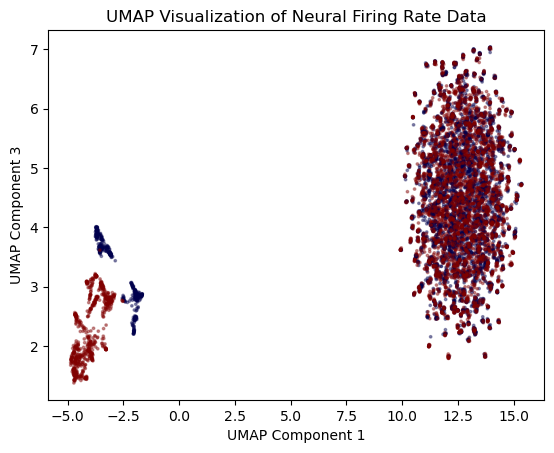

(69, 20158)


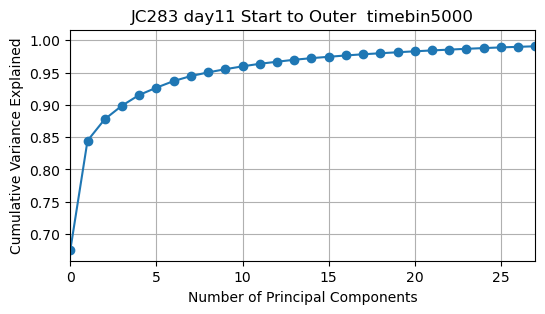

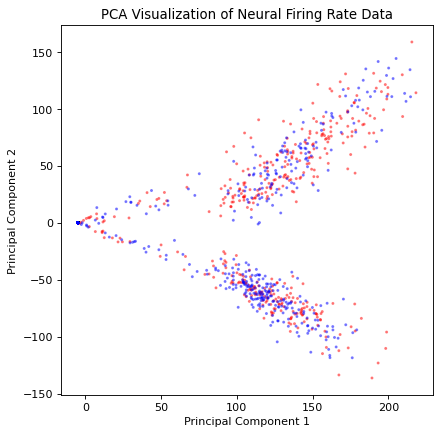

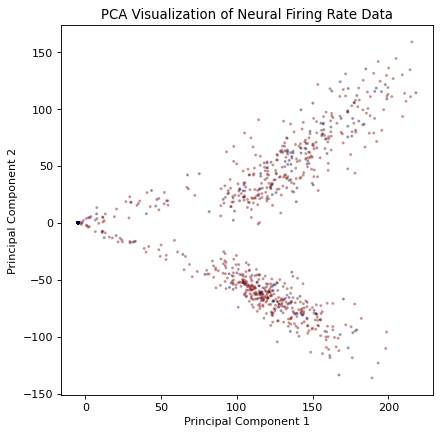

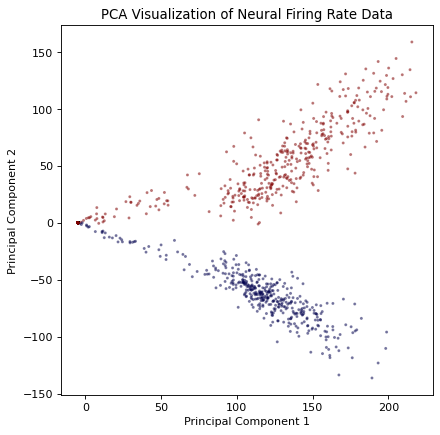

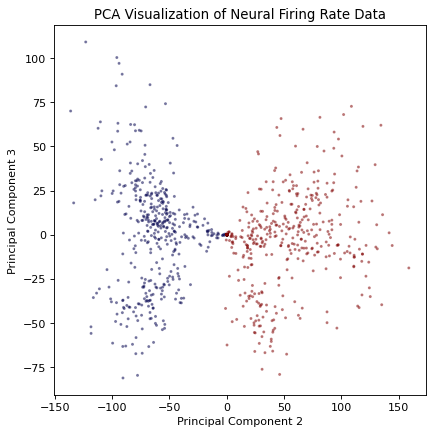

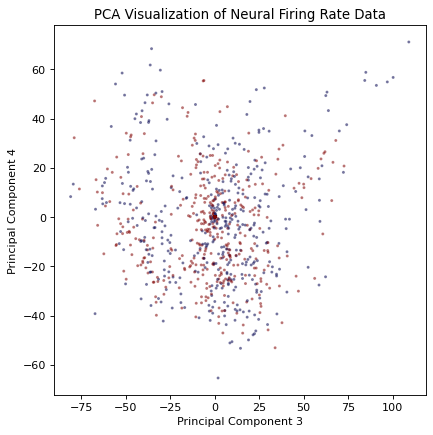

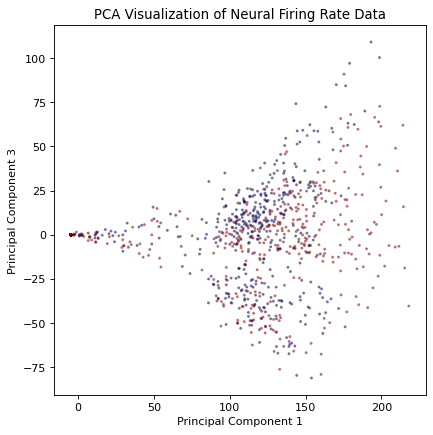

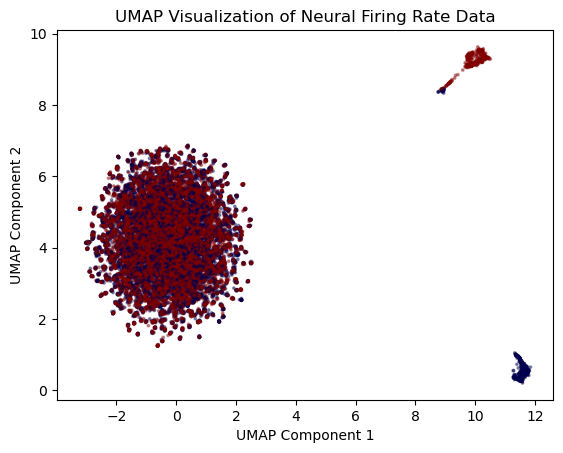

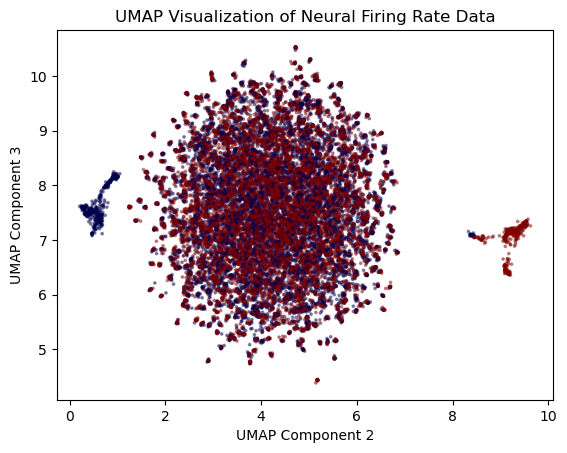

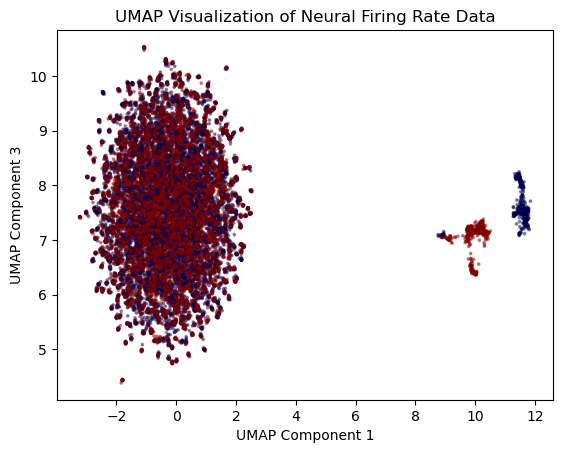

(117, 4758)


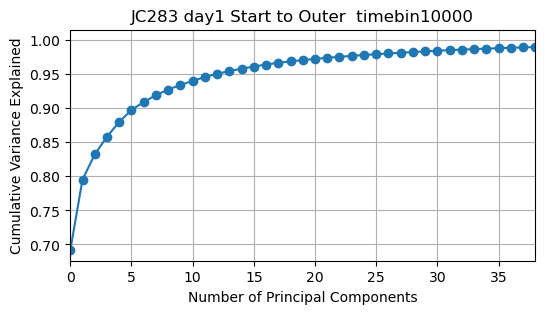

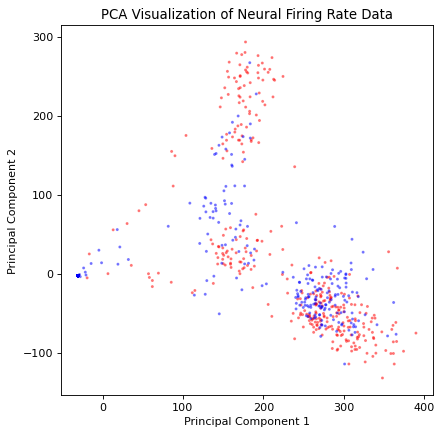

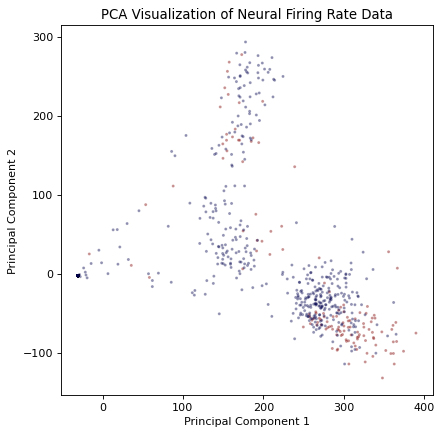

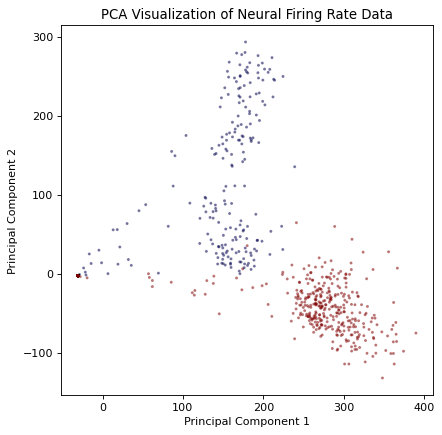

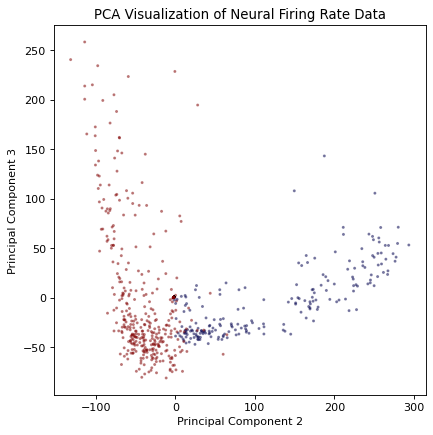

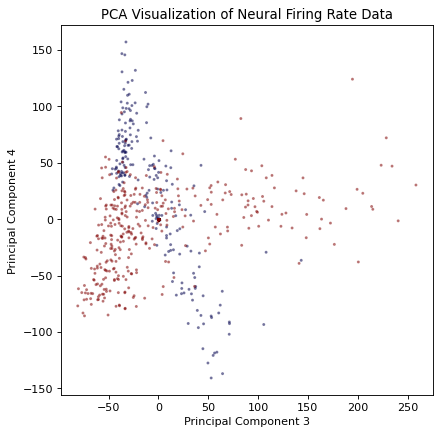

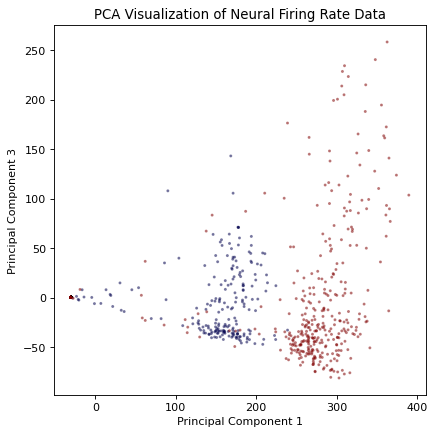

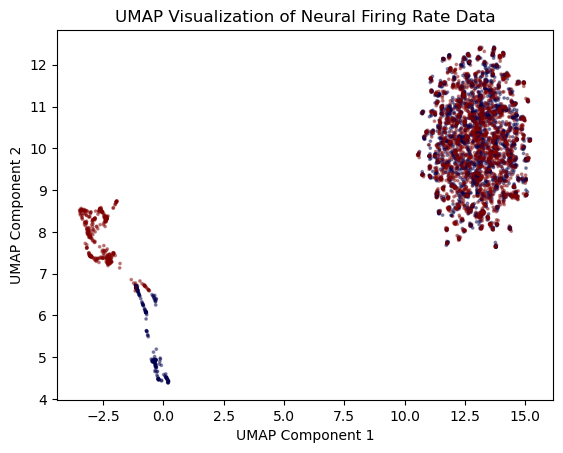

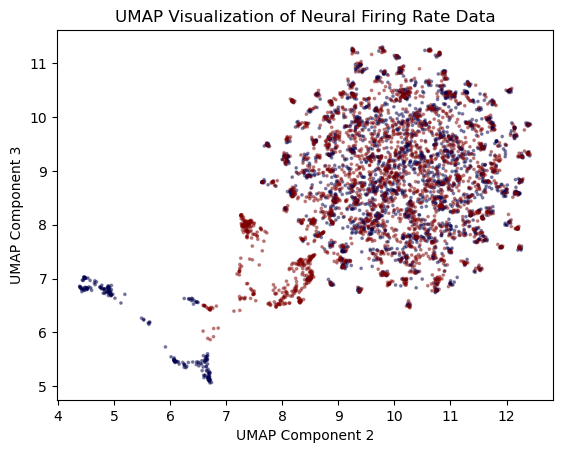

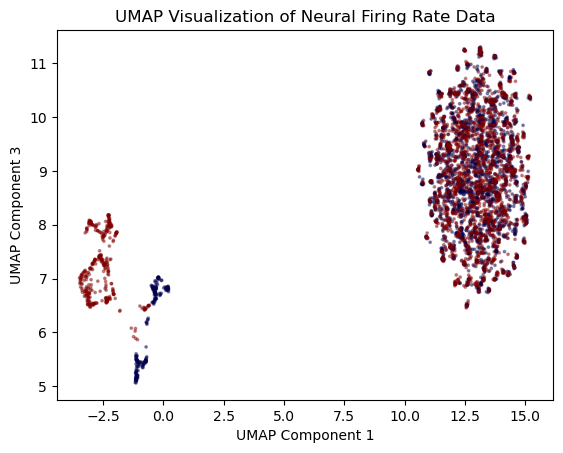

(69, 10095)


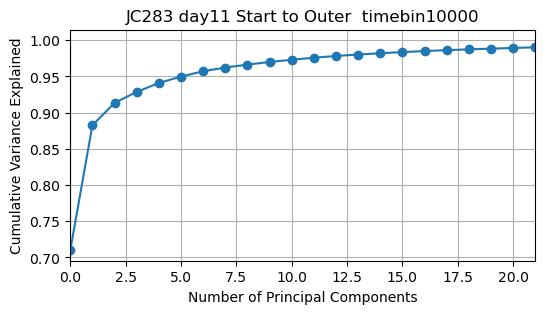

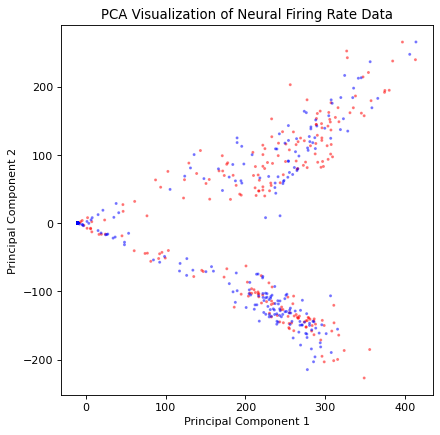

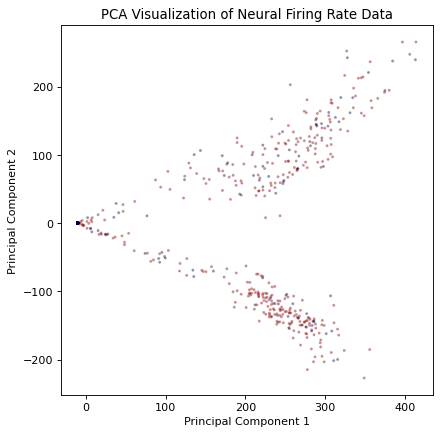

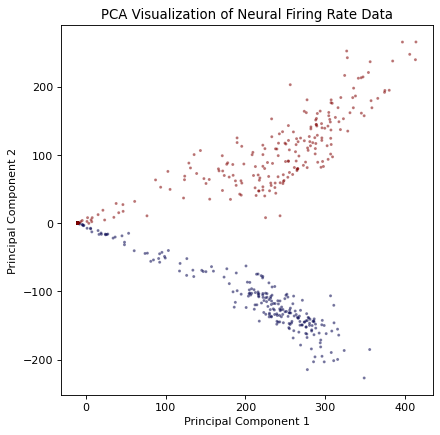

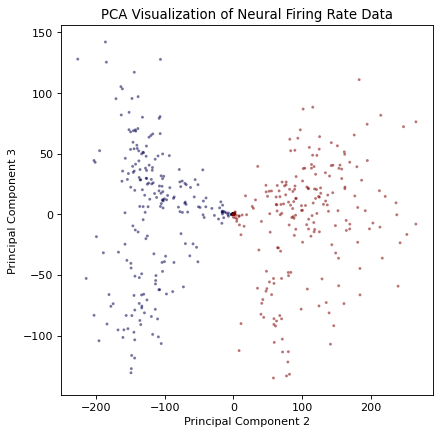

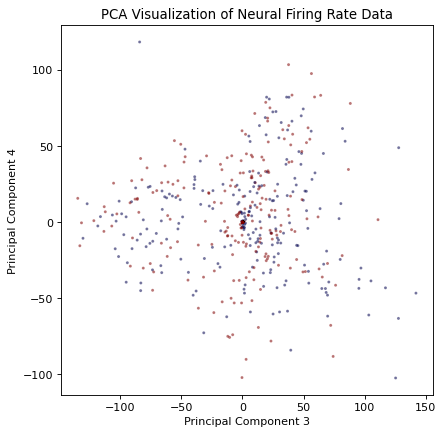

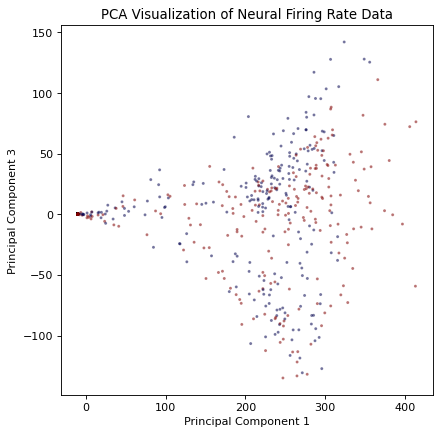

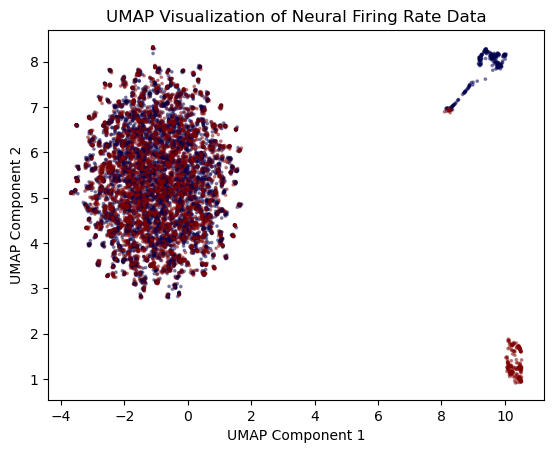

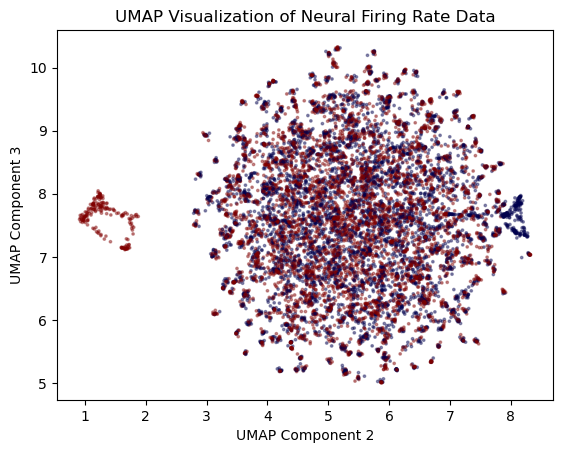

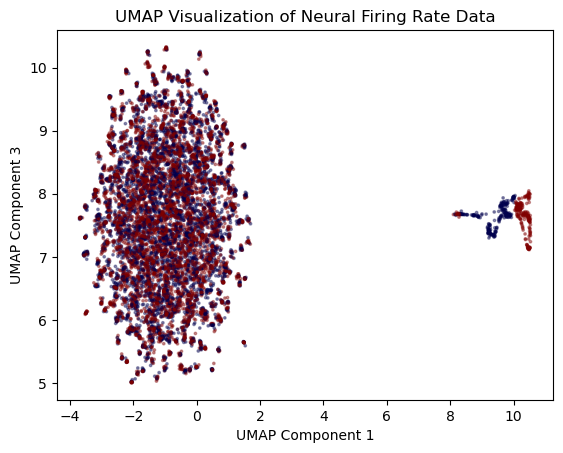

(117, 2386)


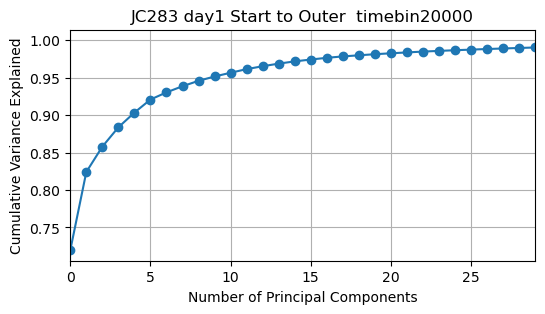

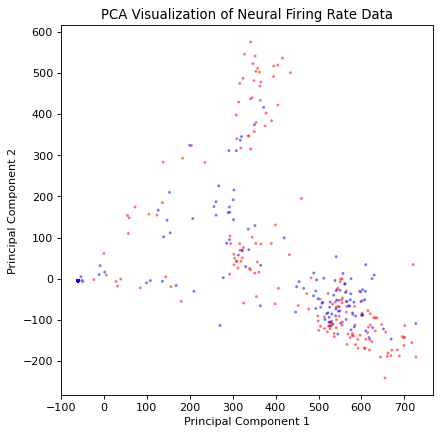

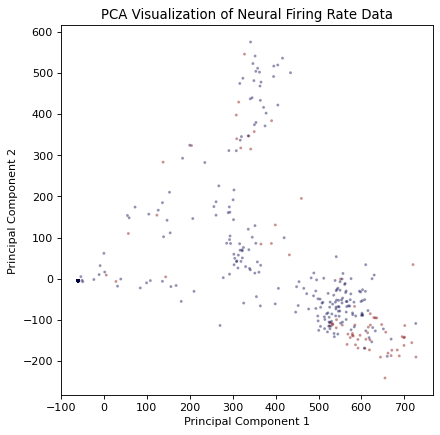

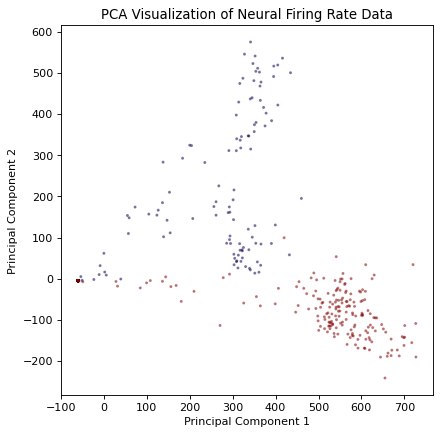

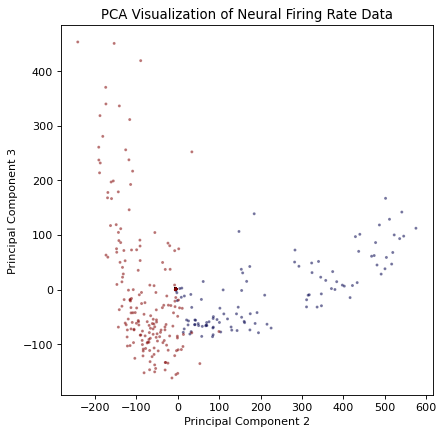

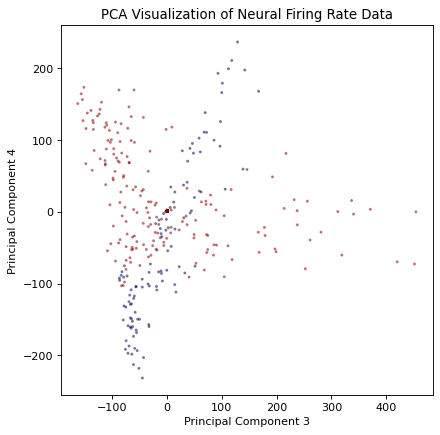

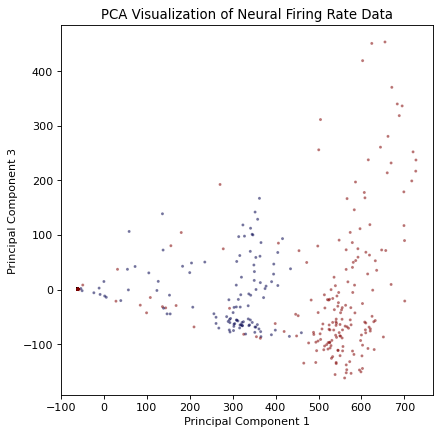

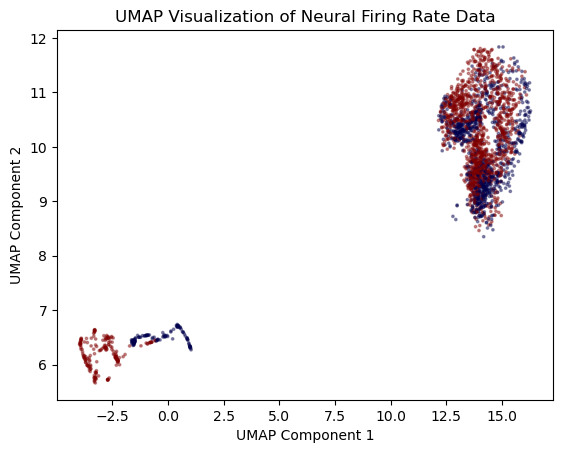

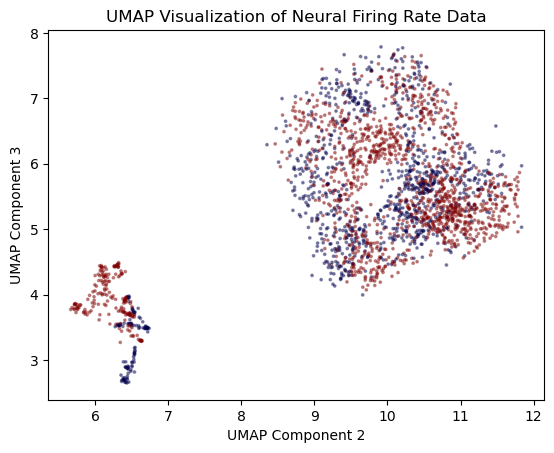

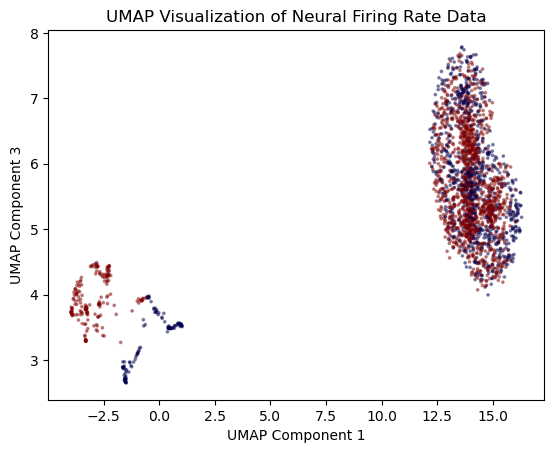

(69, 5063)


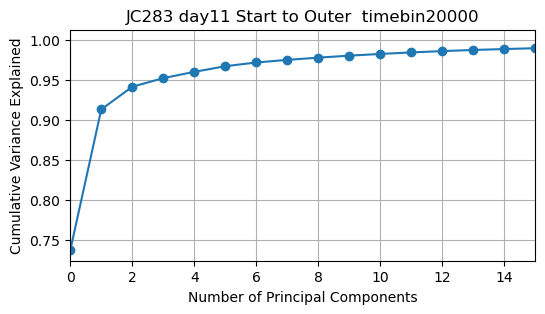

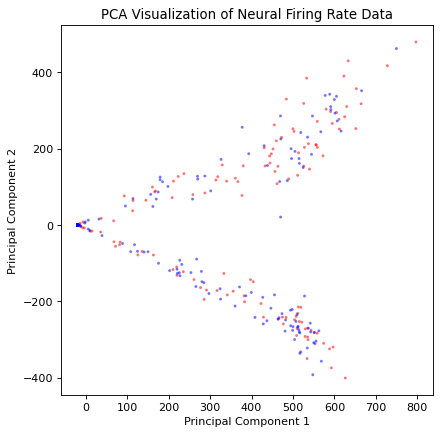

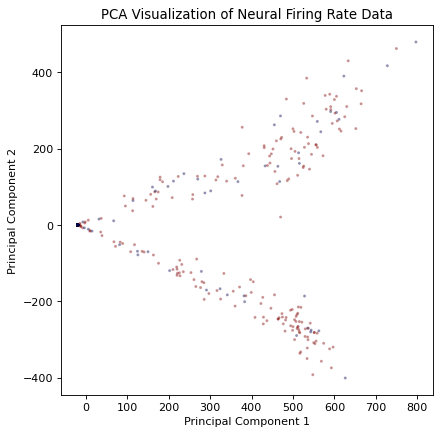

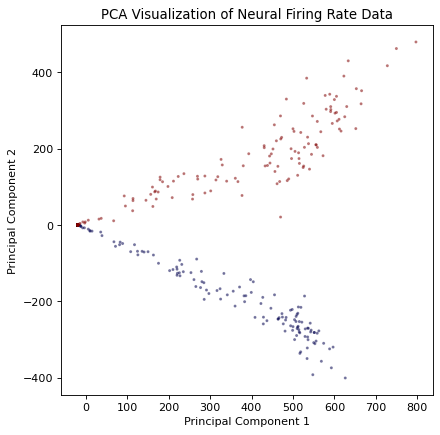

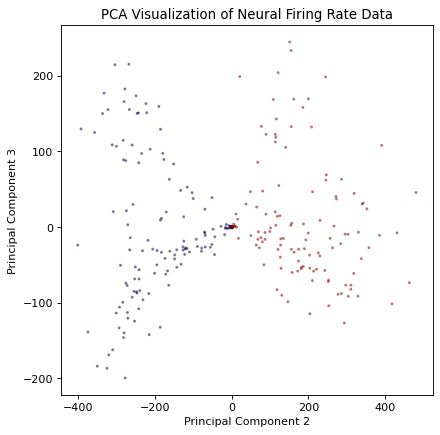

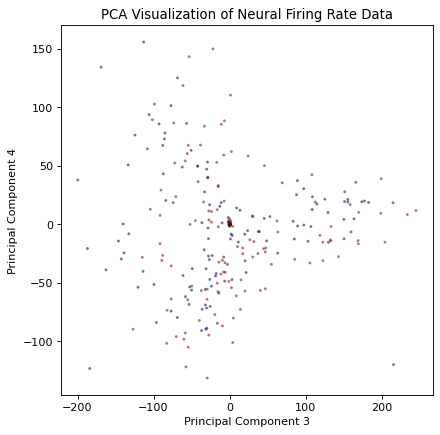

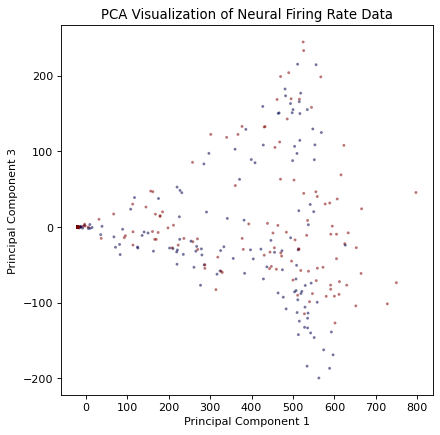

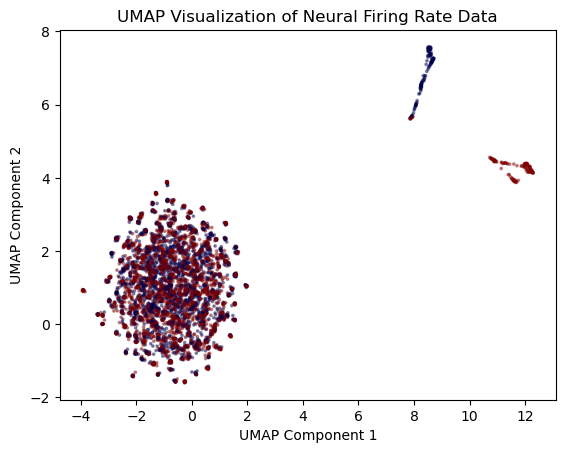

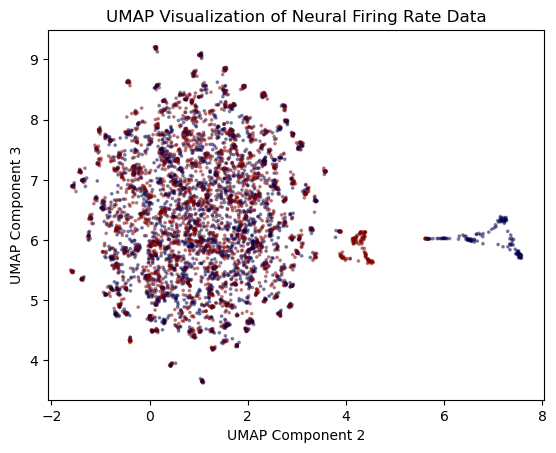

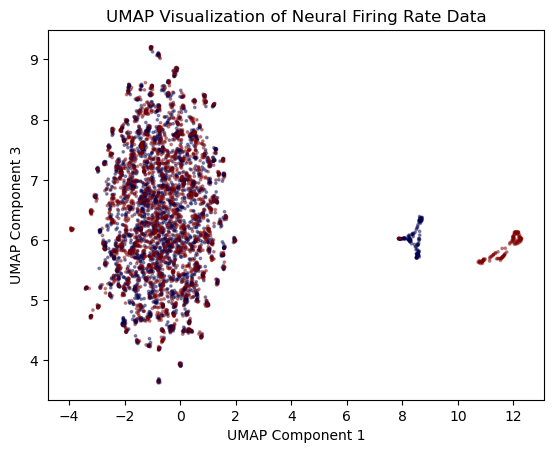

In [25]:
days = ['20220909','20220920']
day_num = {'20220920':11, '20220909':1,'20220910':2}
rats = ["JC283"]
maze_type = 'andrea'
clu_sampling = 20000
whl_sampling = 39.0625
time_bin = 1/whl_sampling # distance between each time stamp in whl (in ms)

whl_to_clu = clu_sampling/whl_sampling
time_bin_widths=[2000, 5000, 10000, 20000]
for time_width in time_bin_widths:
    for rat in rats:
        for day in days:
            path = "./m" + rat + "-" + day + "/"

            des_path = path + rat + "-" + day + '.des'
            with open(des_path, 'r') as file:
                des = np.array(file.read().split())
            bad_cells = []
            for cell_id in range(len(des)):
                if des[cell_id] != "pp":
                    bad_cells.append(cell_id) 
            CY=[]
            CN=[]
            SY=[]
            SN=[]
            behavior_df = pd.read_csv("./JC283_data.csv")
            behavior_df = behavior_df[behavior_df['Session_ID'] == day_num[day]].reset_index(drop =True)
            for index, row in behavior_df.iterrows():
                if row['Flavor'] == "C":
                    if row['Correct'] == "Y":
                        CY.append(index)
                    else:
                        CN.append(index)
                else:
                    if row['Correct'] == "Y":
                        SY.append(index)
                    else:
                        SN.append(index)
            trial_order = CY + CN + SY + SN
            type_ends = [len(CY), len(CN), len(SY), len(SN)]

            spike_matrix = []  
            trial_matrix = []
            trial_type_arr = []
            trial_correct_arr=[]
            sleep_arr=[]

            i=0
            for training_num in [1,2]:

                clu_path = path + rat + "-" + day + '_training' + str(training_num) + '.clu'
                res_path = path+ rat + "-" + day + '_training' + str(training_num) + '.res'
                trial_path = path + rat + "-" + day + '_training' + str(training_num) + '.trials'
                flag = 0
                with open(trial_path,'r') as f:
                    for trial in f:
                        if day == '20220920' and training_num == 2 and i == 12 and flag ==0:
                            flag = 1
                            continue
                        else:
                            trial = np.array(trial.split(" "), dtype = int)

                            spike_times = jcl.load.spike_times_from_res_and_clu( 
                                res_path, clu_path, exclude_clusters=[0, 1],
                                ts_limits = ( trial[0]*whl_to_clu, trial[5]*whl_to_clu) ) 

                            binned_spikes = jcl.load.bins_from_spike_times(
                                 spike_times, bin_len = time_width, return_mat_type = np.array )
                            trial_type_arr.append([behavior_df.iloc[i]['Flavor']]*binned_spikes.shape[1])
                            trial_correct_arr.append([behavior_df.iloc[i]['CorrectBool']]*binned_spikes.shape[1])
                            sleep_arr.append( [training_num ]  *binned_spikes.shape[1]  )
                            spike_matrix.append(binned_spikes)                  
                            trial_matrix.append( (trial - trial[0])*whl_to_clu )
                            i+=1
                            if i==70:
                                break
                    f.close()

            sorted_spike_matrix = []
            sorted_trial_matrix = []
            sorted_trial_type_arr = []
            sorted_trial_correct_arr = []
            sorted_sleep_arr = []
            for i in trial_order:
                sorted_spike_matrix.append(spike_matrix[i])
                sorted_trial_matrix.append(trial_matrix[i])
                sorted_trial_type_arr.append(trial_type_arr[i])
                sorted_trial_correct_arr.append(trial_correct_arr[i])
                sorted_sleep_arr.append(sleep_arr[i])
                
            pca_data = np.concatenate(sorted_spike_matrix, axis = 1)
            trial_types = np.concatenate(sorted_trial_type_arr)
            trial_correct = np.concatenate(sorted_trial_correct_arr)
            sleep_time = np.concatenate(sorted_sleep_arr)
            color = {'C':'red','S':'blue','H':'green'}
            trial_types[trial_types =='S'] = color['S']
            trial_types[trial_types =='C'] = color['C']

            pca_data = np.delete(pca_data, bad_cells, axis=0)
            print(pca_data.shape)

            row_means = np.mean(pca_data, axis=1)
            Z = (pca_data - row_means[:, np.newaxis]) 

            # 2. Calculate the Covariance Matrix
            covariance_matrix = np.cov(Z)
            # 3. Compute the Eigenvectors and Eigenvalues
            eigenvalues, eigenvector = np.linalg.eig(covariance_matrix)
            # 4. Sort Eigenvalues
            sorted_eigenvalues = np.sort(eigenvalues)[::-1]
            # 5. Calculate Variance Explained
            total_variance = np.sum(sorted_eigenvalues)
            variance_explained = sorted_eigenvalues / total_variance

            # 6. Visualize Variance Explained
            plt.figure(figsize = (6,3))
            plt.plot(np.cumsum(variance_explained), marker='o', linestyle='-')
            plt.xlabel('Number of Principal Components')
            plt.ylabel('Cumulative Variance Explained')
            plt.title('Variance Explained by Principal Components')
            plt.xlim([0,np.where(np.cumsum(variance_explained)>0.99)[0][0]])
            plt.title(rat + " day" + str(day_num[day]) + " " + "Start to Outer"+"  timebin"+str(time_width))
            plt.grid()
            plt.show()     
            
#             colors = ['red', 'green', 'blue']
#             cmap = ListedColormap(colors)

            pca = PCA(n_components= np.where(np.cumsum(variance_explained)>0.95)[0][1] )
            projected_data = pca.fit_transform(Z.T) 

            plt.figure(figsize = (6, 6), dpi = 80)
            plt.scatter(projected_data[:, 0], projected_data[:, 1], c=trial_types,s=3, alpha=0.4)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA Visualization of Neural Firing Rate Data')
            plt.show()
            
            plt.figure(figsize = (6, 6), dpi = 80)
            plt.scatter(projected_data[:, 0], projected_data[:, 1], c=trial_correct,s=3, cmap='seismic', alpha=0.3)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA Visualization of Neural Firing Rate Data')
            plt.show()
            
            plt.figure(figsize = (6, 6), dpi = 80)
            plt.scatter(projected_data[:, 0], projected_data[:, 1], c=sleep_time, cmap='seismic', s=3, alpha=0.4)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA Visualization of Neural Firing Rate Data')
            plt.show()
            
            plt.figure(figsize = (6, 6), dpi = 80)
            plt.scatter(projected_data[:, 1], projected_data[:, 2], c=sleep_time, cmap='seismic' ,s=3, alpha=0.4)
            plt.xlabel('Principal Component 2')
            plt.ylabel('Principal Component 3')
            plt.title('PCA Visualization of Neural Firing Rate Data')
            plt.show()
            
            plt.figure(figsize = (6, 6), dpi = 80)
            plt.scatter(projected_data[:,2], projected_data[:,3], c=sleep_time, cmap='seismic',s=3, alpha=0.4)
            plt.xlabel('Principal Component 3')
            plt.ylabel('Principal Component 4')
            plt.title('PCA Visualization of Neural Firing Rate Data')
            plt.show()
            
            plt.figure(figsize = (6, 6), dpi = 80)
            plt.scatter(projected_data[:, 0], projected_data[:, 2], c=sleep_time, cmap='seismic',s=3, alpha=0.4)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 3')
            plt.title('PCA Visualization of Neural Firing Rate Data')
            plt.show()

            reducer = umap.UMAP(n_components=3)  # Reduce to 2D for visualization
            embedding = reducer.fit_transform(Z.T)  # Transpose the data for UMAP
            # 3. Visualize the Reduced Data
            plt.scatter(embedding[:, 0], embedding[:, 1], c=sleep_time, cmap='seismic' ,s=3, alpha=0.4)
            plt.xlabel('UMAP Component 1')
            plt.ylabel('UMAP Component 2')
            plt.title('UMAP Visualization of Neural Firing Rate Data')
            plt.show()
            
            plt.scatter(embedding[:, 1], embedding[:, 2], c=sleep_time, cmap='seismic',s=3, alpha=0.4 )
            plt.xlabel('UMAP Component 2')
            plt.ylabel('UMAP Component 3')
            plt.title('UMAP Visualization of Neural Firing Rate Data')
            plt.show()
            
            plt.scatter(embedding[:, 0], embedding[:, 2], c=sleep_time, cmap='seismic' ,s=3, alpha=0.4)
            plt.xlabel('UMAP Component 1')
            plt.ylabel('UMAP Component 3')
            plt.title('UMAP Visualization of Neural Firing Rate Data')
            plt.show()